In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# 1. Split digits function

In [3]:
img_list = []  # Danh sách lưu trữ các ảnh đã xử lý

def preprocess_image_multi_digits(image_path, output_folder = "./digits_split_output", padding = 10):
    if not os.path.exists(image_path):
        print("Lỗi: Ảnh '" + image_path + "' không tồn tại!")
        return 0

    # Đọc ảnh gốc (Grayscale)
    img_org = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_list.append(img_org)    #1

    if img_org is None:
        print(f"Lỗi: Không thể đọc {image_path}")
        return

    img = cv2.GaussianBlur(img_org, (5,5), 0)

    # Apply OTSU thresholding
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Giãn nở
    kernel = np.ones((5,5), np.uint8)  # Kích thước kernel lớn hơn để nối nét
    img = cv2.dilate(img, kernel, iterations=1)

    img_list.append(img)    #2

    # Tìm contours của các chữ số
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Chuyển ảnh về BGR để vẽ màu
    img_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Vẽ contours lên ảnh
    cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)
    img_contours_org = img_contours.copy()

    # Sắp xếp contours theo tọa độ x để đúng thứ tự từ trái qua phải
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

    # Split digits
    digit_regions = []
    for idx, contour in enumerate(contours, start = 1):
        x, y, w, h = cv2.boundingRect(contour)

        x = max(x - padding, 0)
        y = max(y - padding, 0)
        w = min(w + 2 * padding, img.shape[1] - x)
        h = min(h + 2 * padding, img.shape[0] - y)

        cv2.rectangle(img_contours, (x, y), (x + w, y + h), (0, 0, 255), 2)
        text_position = (x, y - 10)
        cv2.putText(img_contours, f"#{idx}", text_position, cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, (255, 0, 0), 2, cv2.LINE_AA)

        digit_regions.append((x, y, w, h))

    img_list.append(img_contours)  # 3

    # Xử lý dấu "=" - Merge box
    fixed_digit_regions = []
    for items in range(0, len(digit_regions) - 1):
        x0, y0, w0, h0 = digit_regions[items]
        x1, y1, w1, h1 = digit_regions[items + 1]

        disparity = abs(x1 - x0)
        if disparity <= 10:
            h0 = abs(y1 - y0) + h1
            w0 = max(w0, w1)
            x0 = min(x0, x1)
            y0 = min(y0, y1)
            items += 1

        fixed_digit_regions.append((x0, y0, w0, h0))
        if items == len(digit_regions) - 2 and disparity > 10:
            fixed_digit_regions.append((x1, y1, w1, h1))

    # Draw
    for idx in range(0, len(fixed_digit_regions)):
        x, y, w, h = fixed_digit_regions[idx]

        cv2.rectangle(img_contours_org, (x, y), (x + w, y + h), (0, 0, 255), 2)

        text_position = (x, y - 10)
        cv2.putText(img_contours_org, "#{}".format(idx + 1), text_position, cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, (255, 0, 0), 2, cv2.LINE_AA)

    img_list.append(img_contours_org)   #4

    # Thư mục lưu ảnh
    if not os.path.exists("digit_split_raw_img"):
        os.makedirs("digit_split_raw_img")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Cắt và lưu từng chữ số
    for i, (x, y, w, h) in enumerate(fixed_digit_regions):
        digit = img_org[y:y + h, x:x + w]
        cv2.imwrite(f"./digit_split_raw_img/digit_{i}.png", digit)

        digit = img[y:y + h, x:x + w]
        digit = cv2.resize(digit, (28, 28), interpolation=cv2.INTER_AREA)
        _, digit = cv2.threshold(digit, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        digit = abs(255 - digit)
        # digit = abs(digit - 255)

        cv2.imwrite(f"{output_folder}/digit_{i}.png", digit)

    print(f"Đã tách {len(fixed_digit_regions)} chữ số và lưu vào thư mục '{output_folder}'.")

    return len(fixed_digit_regions)

# 2. Implementation

In [6]:
img_path = "..\..\images\image1.png"  # Đường dẫn đến ảnh gốc
preprocess_image_multi_digits(img_path, output_folder = "digits_split_output", padding = 10)

Đã tách 4 chữ số và lưu vào thư mục 'digits_split_output'.


4

# 3. Show result

In [8]:
def all_processes_gui(img_list):
    rows, cols = 2, 2  # Ví dụ: 2 hàng, 2 cột
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < len(img_list): 
            ax.imshow(img_list[i], cmap='gray')
            ax.set_title(f"Image {i + 1}")
            ax.axis("off")  
    plt.tight_layout()
    plt.show()

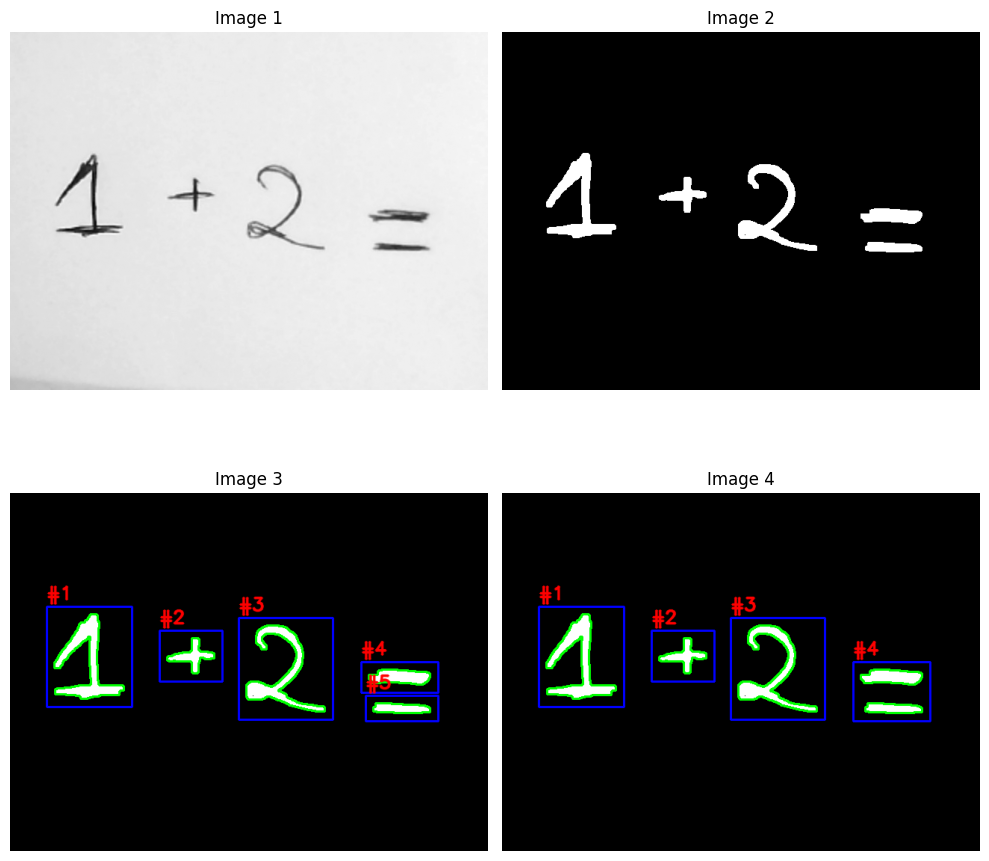

In [9]:
all_processes_gui(img_list)